In [23]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')

# patient='id008_gc'
patient ='id013_pg'
expname = 'exp005'
metadatadir = os.path.join(root_dir, "metadata", patient)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

tvbsim.util.renamefiles(patient, metadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
seegfile = getfilepath('seeg.txt')
gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!


In [142]:
''' THE REAL CLINICALLY ANNOTATED AREAS '''
#001
if 'id001' in patient:
    ezregions = ['ctx-rh-lateralorbitofrontal', 'ctx-rh-temporalpole']
    pzregions = ['ctx-rh-superiorfrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-lateralorbitofrontal']

# 008
if 'id008' in patient:
    ezregions = ['Right-Amygdala', 'Right-Hippocampus']
    pzregions = ['ctx-rh-superiortemporal', 'ctx-rh-temporalpole', 'ctx-rh-inferiortemporal',
     'ctx-rh-medialorbitofrontal', 'ctx-rh-lateralorbitofrontal']

# 013
if 'id013' in patient:
    ezregions = ['ctx-rh-fusiform']
    pzregions = ['ctx-rh-inferiortemporal','Right-Hippocampus','Right-Amygdala', 
          'ctx-rh-middletemporal','ctx-rh-entorhinal']

# 014
if 'id014' in patient:
    ezregions = ['Left-Amygdala', 'Left-Hippocampus', 'ctx-lh-entorhinal', 'ctx-lh-fusiform',
         'ctx-lh-temporalpole','ctx-rh-entorhinal']
    pzregions = ['ctx-lh-superiortemporal', 'ctx-lh-middletemporal', 'ctx-lh-inferiortemporal',
         'ctx-lh-insula', 'ctx-lh-parahippocampal']

In [154]:
# initialize structural connectivity and main simulator object
con = connectivity.Connectivity.from_file(os.path.join(metadatadir, "connectivity.zip"))
maintvbexp = tvbsim.MainTVBSim(con, condspeed=np.inf)
# load the necessary data files to run simulation
maintvbexp.loadseegxyz(seegfile=seegfile)
maintvbexp.loadgainmat(gainfile=gainfile)
maintvbexp.loadsurfdata(directory=metadatadir, use_subcort=False)

# set ez/pz regions
pzregions = []
# ezregions = []
maintvbexp.setezregion(ezregions=ezregions)
maintvbexp.setpzregion(pzregions=pzregions)
print(maintvbexp.ezind)
print(maintvbexp.ezregion)
print(maintvbexp.pzregion)
print(maintvbexp.conn.speed)

NOT USING SUBCORT
[54]
['ctx-rh-fusiform']
None
[inf]


In [165]:
# setup models and integrators
######### Epileptor Parameters ##########
epileptor_r = 0.00035#/1.5   # Temporal scaling in the third state variable
epiks = -2                  # Permittivity coupling, fast to slow time scale
epitt = 0.05                   # time scale of simulation
epitau = 10                 # Temporal scaling coefficient in fifth st var
x0norm=-2.35 # x0c value = -2.05
x0ez=-1.85
x0pz=-2.2
if maintvbexp.ezregion is None:
    x0ez = None
if maintvbexp.pzregion is None:
    x0pz = None
######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                      0.0001, 0.0001, 0.])
ntau = 5
# noise_cov = np.array([1.001, 1.001, 0.,\
#                       1.0001, 1.0001, 0.])*1.2
# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 75*_samplerate    
period = 1./_factor

maintvbexp.initepileptor(x0norm=x0norm, x0ez=x0ez, x0pz=x0pz,
                        r=epileptor_r, Ks=epiks, tt=epitt, tau=epitau)
maintvbexp.initintegrator(ts=heun_ts, noise_cov=noise_cov, ntau=ntau)

In [166]:
dist = 20
for ind in maintvbexp.ezind:
    new_seeg_xyz, elecindicesmoved = maintvbexp.move_electrodetoreg(ind, dist)
print(elecindicesmoved)
print(maintvbexp.seeg_labels[elecindicesmoved])

simplegain = maintvbexp.simplest_gain_matrix()
maintvbexp.gainmat = simplegain
# print(simplegain.shape)
print(x0ez)
print(x0pz)
print(maintvbexp.getepileptorparams())

if dist < 1:
    dist = 0


elec label is OT
12.000000000000005
7.999999999999997
20
[26, 27, 28, 29, 30, 31, 32, 33, 34]
['OT1' 'OT2' 'OT3' 'OT4' 'OT5' 'OT6' 'OT7' 'OT8' 'OT9']
Computing simple gain mat!
-1.85
None
{'ntau': 5, 'tau': array([10]), 'nsig': array([0.001 , 0.001 , 0.    , 0.0001, 0.0001, 0.    ]), 'tt': array([0.05]), 'ks': array([-2]), 'r': array([0.00035]), 'x0': array([-2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -1.85, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35, -2.35,
       -2.35, -

In [167]:
# maintvbexp.gain_matrix_inv_square()
configs = maintvbexp.setupsim(a=1., period=period, moved=False)
display(configs)
times, epilepts, seegts = maintvbexp.mainsim(sim_length=sim_length)

initial_conditions,None
coupling,Difference(a=1)
stimulus,None
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=5))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]"


In [168]:
allindices = np.append(maintvbexp.ezind, maintvbexp.pzind, axis=0).astype(int)
secstoreject = 15

postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
times, epits, seegts, zts = postprocessor.postprocts(epilepts, seegts, times, secstoreject=secstoreject)

# get the onsettimes and offsettimes for ez/pz indices
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.2/5)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

freqrange = [0.1, 499]
# linefreq = 60
noisemodel = tvbsim.postprocess.filters.FilterLinearNoise(samplerate=_samplerate)
seegts = noisemodel.filter_rawdata(seegts, freqrange)
# seegts = noisemodel.notchlinenoise(seegts, freq=linefreq)
print(seegts.shape)
print(zip(seizonsets,seizoffsets))

(59, 60000)
[(9262, 18011), (36926, 44775)]


In [169]:
metadata = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': maintvbexp.conn.region_labels,
        'regions_centers': maintvbexp.conn.centres,
        'chanlabels': maintvbexp.seeg_labels,
        'seeg_xyz': maintvbexp.seeg_xyz,
        'ez': maintvbexp.ezregion,
        'pz': maintvbexp.pzregion,
        'ezindices': maintvbexp.ezind,
        'pzindices': maintvbexp.ezind,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'patient':patient,
        'epiparams': maintvbexp.getepileptorparams()
    }

# if dist != -1:
filename = os.path.join(outputdatadir, 
        patient+'_dist' + str(dist) + '_coloredv2.npz')
npfile = open(filename, 'wb')
# save tseries
np.savez_compressed(npfile, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=metadata)

print("file saved at: ", filename)

('file saved at: ', '/Users/adam2392/Documents/pydata/tvbforwardsim/exp005/id013_pg_dist20_coloredv2.npz')


[0.0015244526566001938, 0.0007276329879837077, 0.0005329733432063218, 0.00042732329770270967, 0.00034270279940136863, 0.0003154529340827299, 0.000301062080407589, 0.0002838221714836961, 0.0002636157617106825, 0.006566313593113251, 0.004436391970959466, 0.0022062305043943466, 0.0012216031949273587, 0.0007643231951026789, 0.0005223258929519468, 0.0017029070350320686, 0.0025859537195086326, 0.0033820014799318472, 0.003128515523219815, 0.0022145271381301826, 0.0014747044519274962, 0.0010120430040041163, 0.000989682691866989, 0.0010656693800071308, 0.0010823804115513412, 0.001018262988171004, 0.0, 0.01726607817898088, 0.004404277355483604, 0.0028728076729139266, 0.003522612340763332, 0.0030771192375081686, 0.002111782060110192, 0.0013870623710290414, 0.0009428421668013554, 0.00041912774097534834, 0.0004272685541194067, 0.000584002582682465, 0.0008020124390198479, 0.0010690308249330642, 0.00128104832067851, 0.0003289641319386233, 0.00043340388604619985, 0.000612037458275434, 0.00091109942571

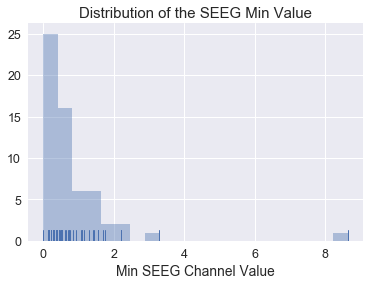

In [132]:
sigvals = []
for idx, sig in enumerate(seegts):
    sigvals.append(np.max(sig))

print(sigvals)
    
fig = plt.figure()
sns.set(font_scale=1.25)
sns.distplot(np.multiply(sigvals,500), kde=False, rug=True,
             axlabel='Min SEEG Channel Value')
plt.title('Distribution of the SEEG Min Value')
ax = plt.gca()
# ax.set_xticks(np.arange(0,60,5))

# Apply Visualization of The Data

In [170]:
brainplotter = tvbsim.visualize.plotbrain.VisualBrain()
brainplotter.setfigsize(figsize=(20,17))
brainplotter.loadsurf(maintvbexp.vertices)
brainplotter.loadseeg(maintvbexp.seeg_xyz, maintvbexp.seeg_labels)
brainplotter.loadregs(maintvbexp.conn.centres, maintvbexp.conn.region_labels)
brainplotter.setcontacts()

Nbre_contacts_per_electrode: [9, 6, 11, 9, 6, 9, 9]
Nbre_electrodes: 7
Ending Index of electrodes: [ 9 15 26 35 41 50 59]


id013_pg
num regions:  84
num contacts:  59
7
xreg:  (84,)
yreg:  (84,)
zreg:  (84,)


(<matplotlib.figure.Figure at 0x114c33910>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1685dacd0>)

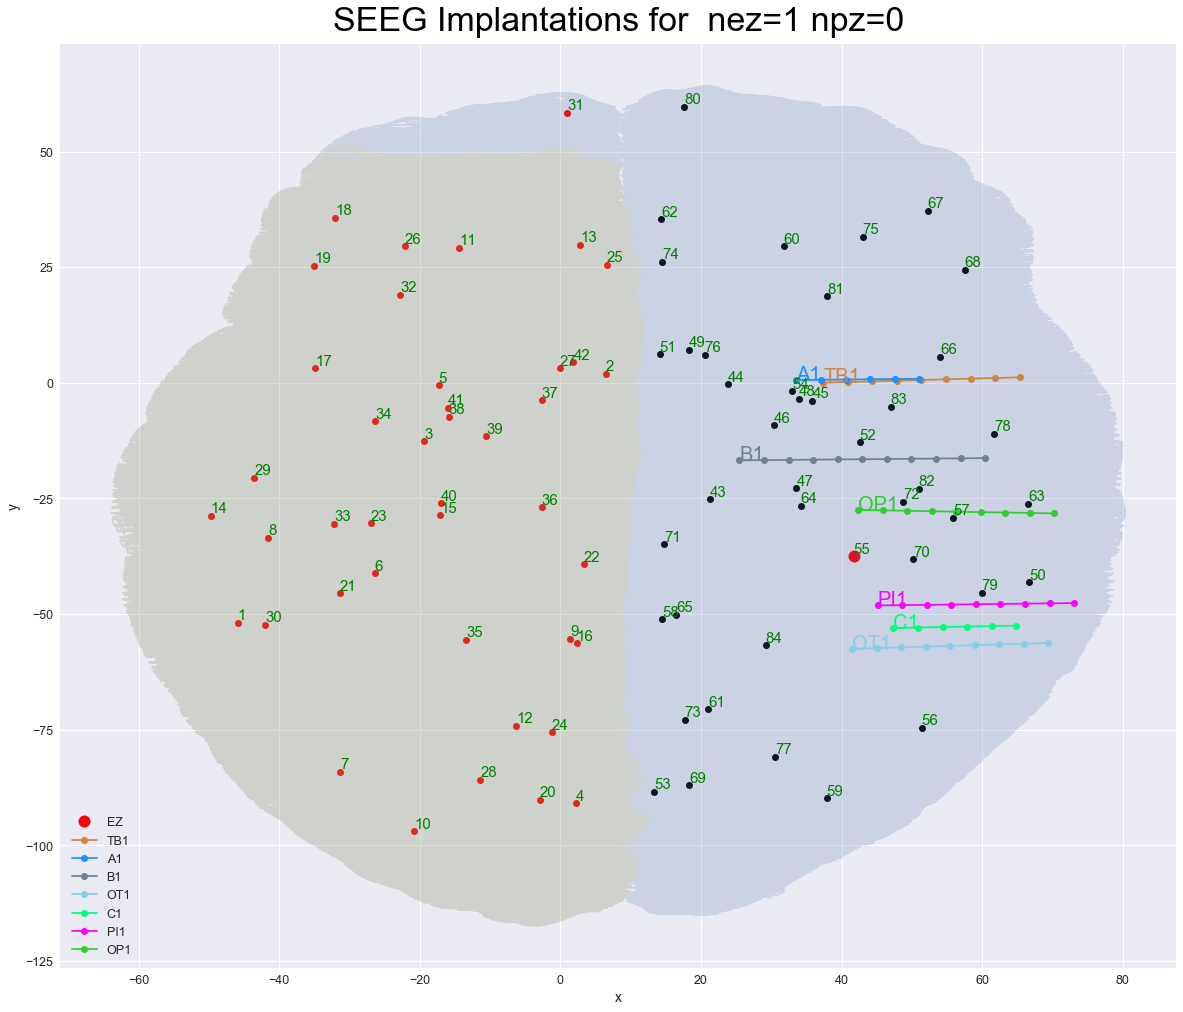

In [171]:
print(patient)
brainplotter.plotcontactsinbrain(maintvbexp.ezind, maintvbexp.pzind)

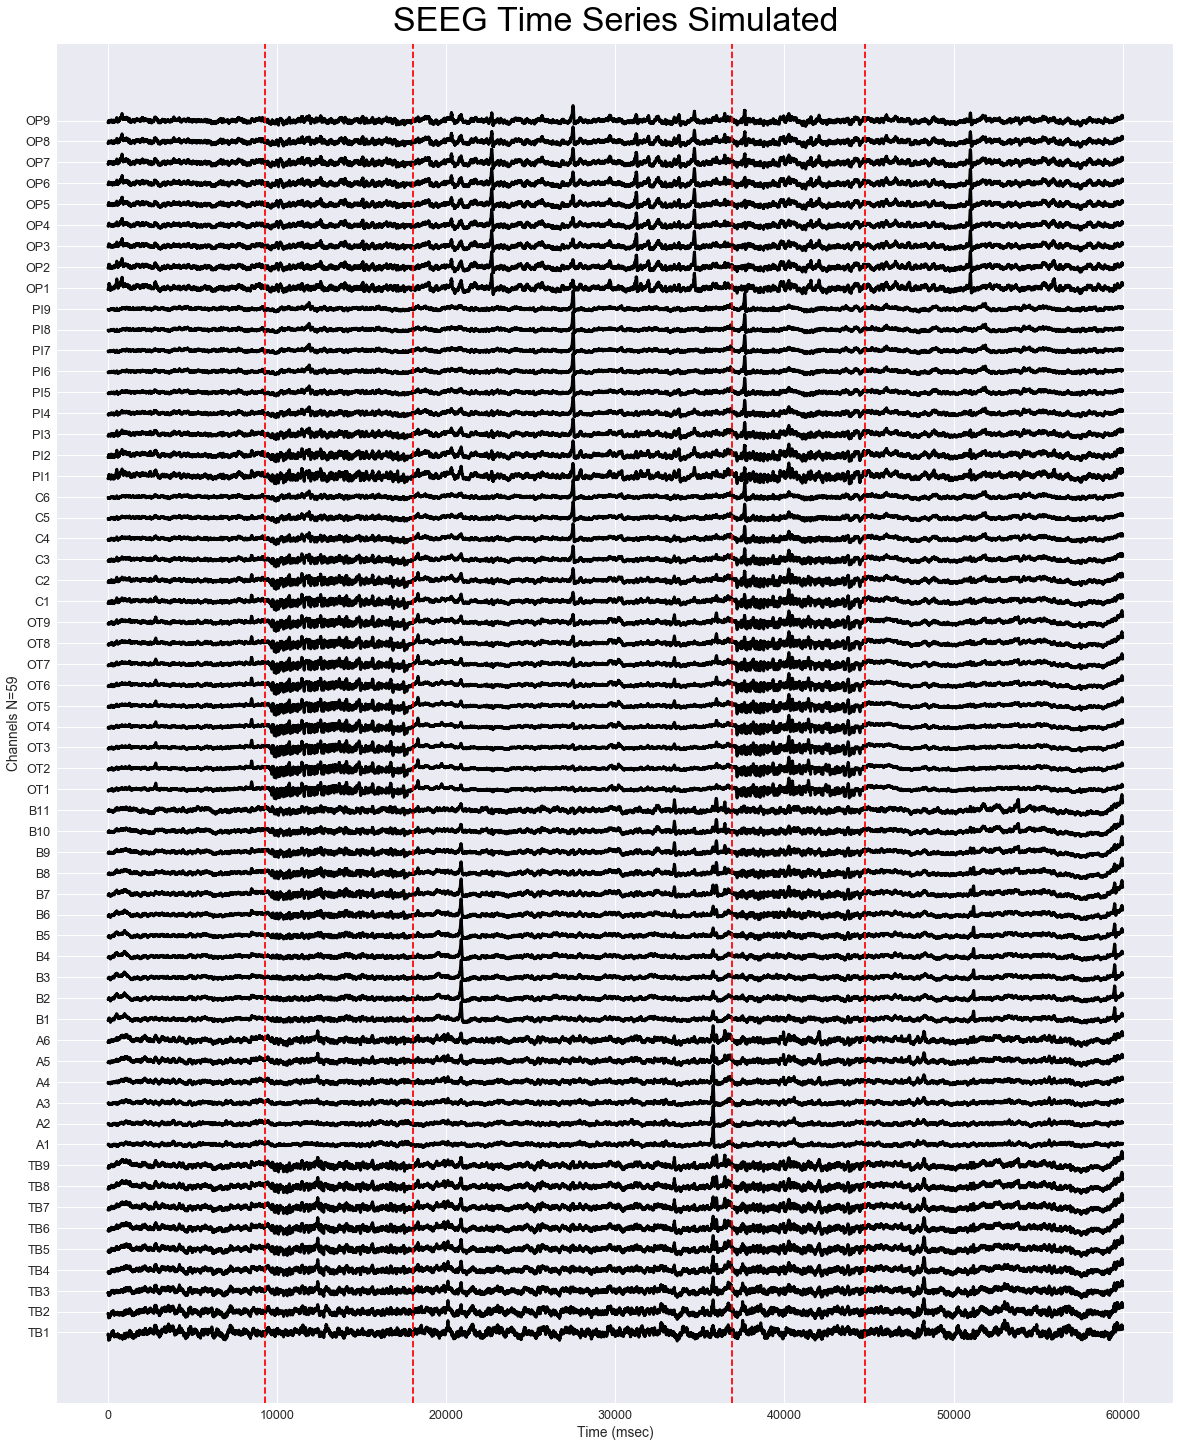

In [172]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=seegts,ylabels=maintvbexp.seeg_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
# tsviz.colorts(maintvbexp.ezind, color=colors[0])

5.954971957272562e+17
(59, 59)


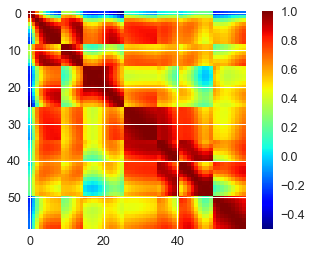

In [173]:
winsizems = 2500
corr = np.corrcoef(seegts[:, 0:winsizems])
# corr = np.cov(seegts[:, 0:winsizems])
print(np.linalg.cond(corr))
print(corr.shape)
plt.imshow(corr, cmap='jet')
plt.colorbar()

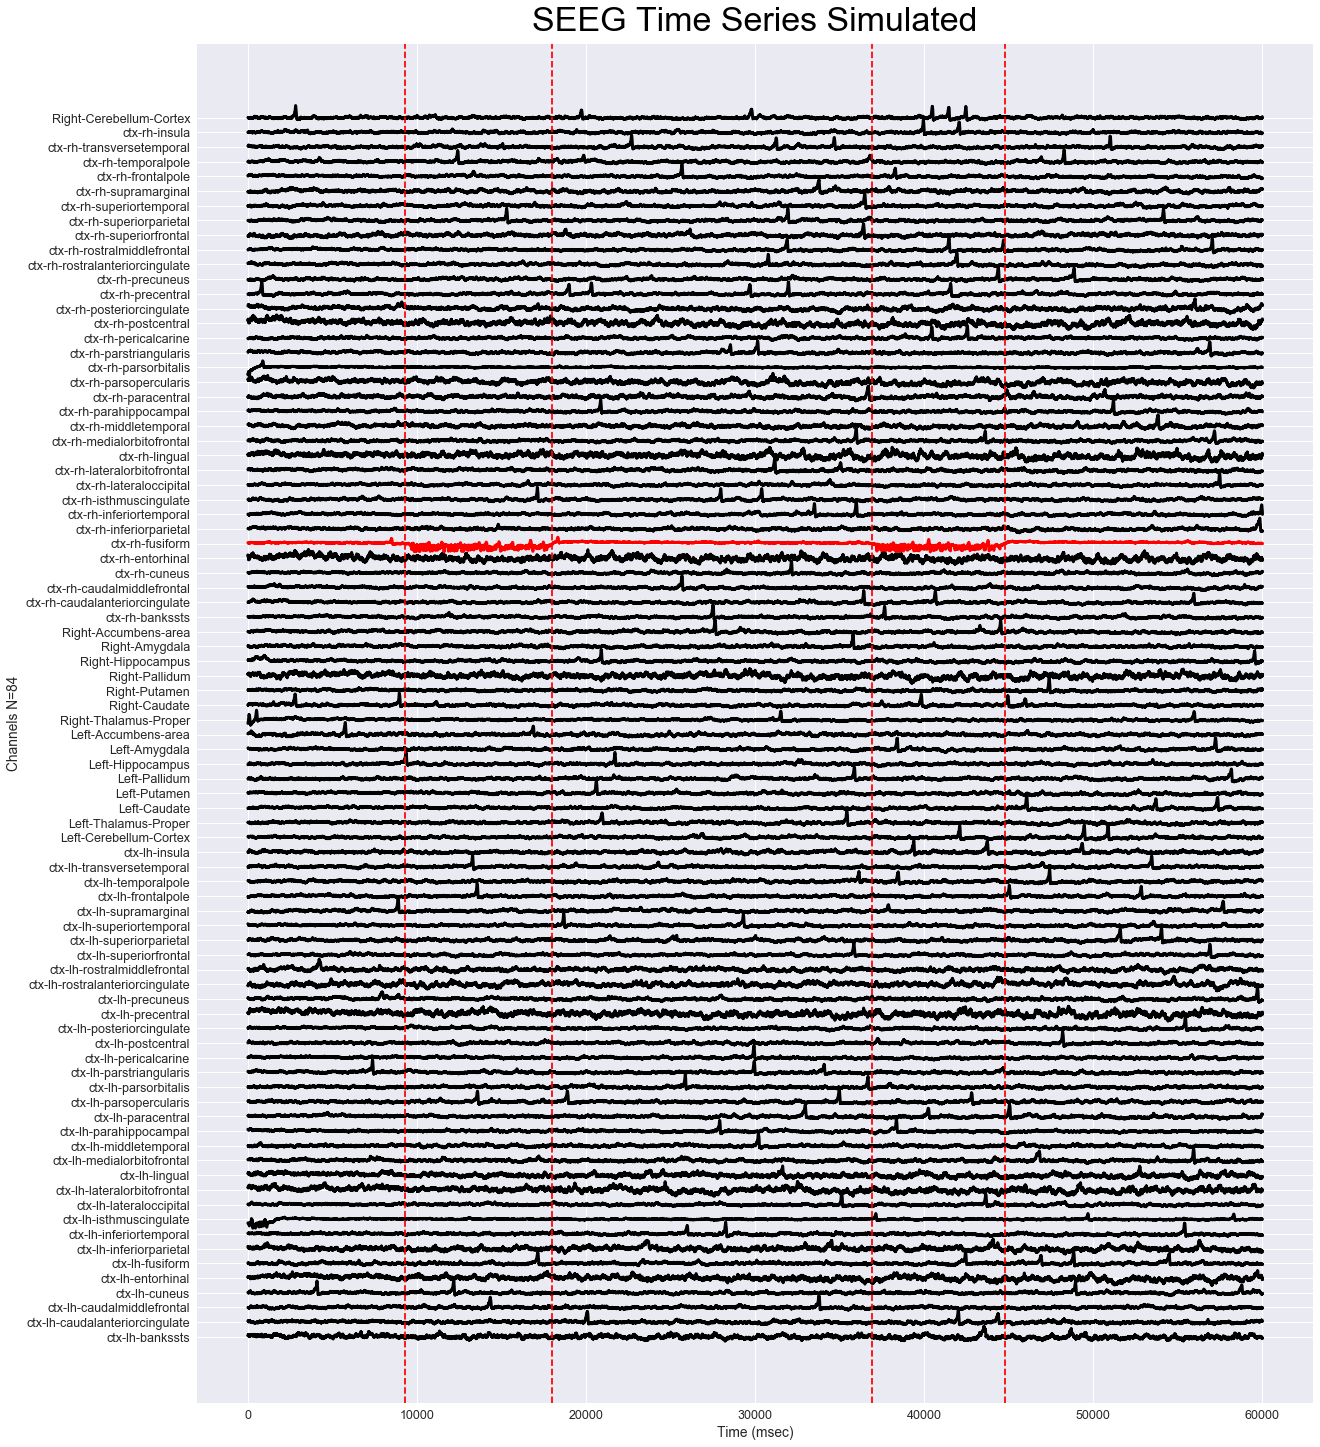

In [174]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=maintvbexp.conn.region_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(maintvbexp.ezind, color='red')

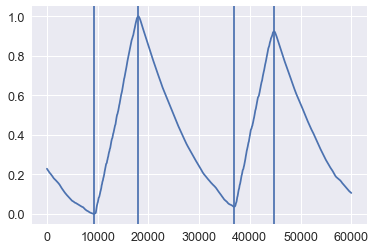

In [103]:
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler()
# get the onsettimes and offsettimes for ez/pz indices
# postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
# settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=0.8)# get the actual seizure times and offsets
# seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

# print(settimes)
# test = 
# plt.plot(epits[maintvbexp.ezind[0],5000:25000])
plt.plot(scaler.fit_transform(zts[maintvbexp.ezind[0],:].reshape(-1, 1)))
for i in seizonsets:
    plt.axvline(i)
for i in seizoffsets:
    plt.axvline(i)
# plt.axhline(np.mean(scaler.fit_transform(zts[maintvbexp.ezind[0],:].reshape(-1, 1))))

In [94]:
for idx, delt in enumerate([0.2/4, 0.2, 0.6, 0.8]):
    settimes = postprocessor.getonsetsoffsets(zts, allindices, delta=delt)# get the actual seizure times and offsets
    
    if idx == 0:
        allsettimes = settimes
    else:
        allsettimes = np.append(allsettimes, settimes, axis=0)

print(set(allsettimes))

TypeError: unhashable type: 'numpy.ndarray'

In [71]:
print(maintvbexp.conn.centres[maintvbexp.ezind])
for ind in maintvbexp.ezind:
    print(maintvbexp.findclosestcontact(ind))

[[ 41.72   -37.5433 -31.4786]]
(26, 14.507025155075729)


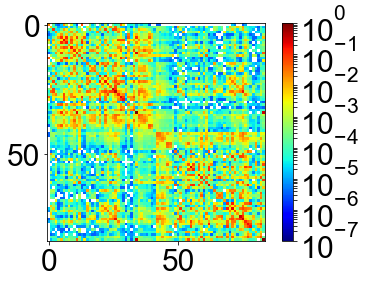

In [35]:
from matplotlib import colors, cm
plt.figure()
image = maintvbexp.conn.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=cm.jet)
plt.colorbar()
#max(con.weights[con.weights != 0])